In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

from collections import defaultdict
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
num_classes = 100  # Number of classes in CIFAR-100
input_shape = (32, 32, 3)

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

print("x_data shape:", x_data.shape, "- y_data shape:", y_data.shape)

# CIFAR-100 classes
classes = [
    "apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle",
    "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
    "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock",
    "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur",
    "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster",
    "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion",
    "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain",
    "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree",
    "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine",
    "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea",
    "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider",
    "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank",
    "telephone", "television", "tiger", "tractor", "train", "trout", "tulip",
    "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"
]

x_data shape: (60000, 32, 32, 3) - y_data shape: (60000, 1)


In [3]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [4]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
data_preprocessing.layers[-1].adapt(x_data)


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)


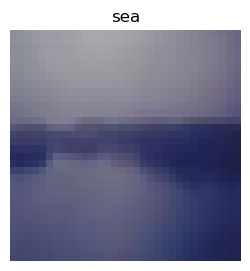

In [6]:
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype("uint8"))
plt.title(image_class)
_ = plt.axis("off")

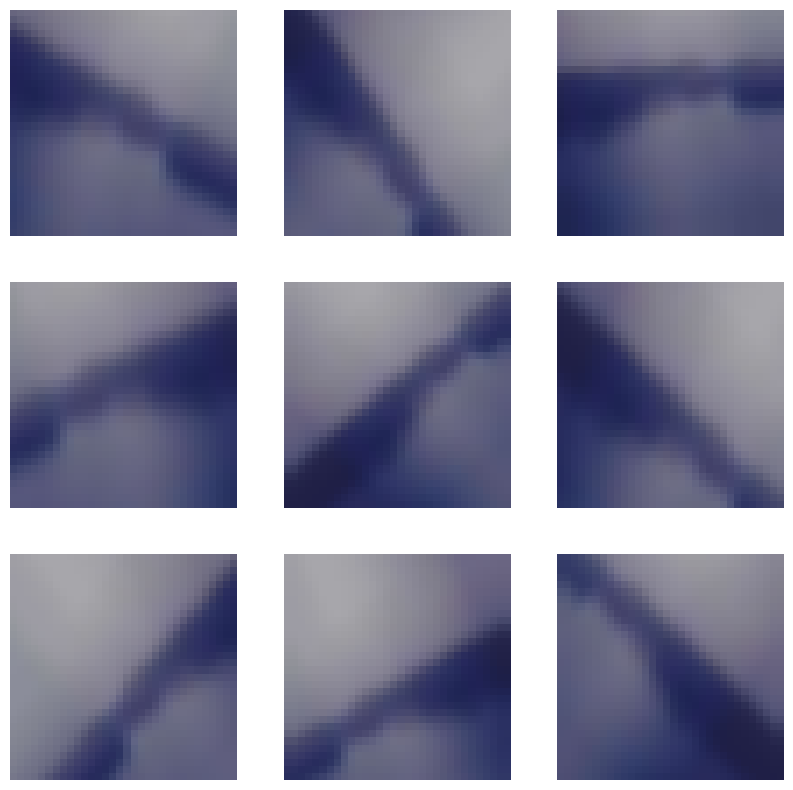

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [9]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

In [10]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = keras.ops.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = keras.utils.normalize(feature_vectors)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = keras.ops.max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = keras.ops.tile(
            tf.eye(batch_size), [num_augmentations, num_augmentations]
        )
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = keras.ops.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [11]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
    jit_compile=False,
)
# Fit the model.
history = representation_learner.fit(
    x=x_data,
    batch_size=512,
    epochs=5,  # for better results, increase the number of epochs to 500.
)

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 881s 7s/step - loss: 127.0269
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 978s 8s/step - loss: 12.3749
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 820s 7s/step - loss: 10.8631
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 840s 7s/step - loss: 10.0816
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 828s 7s/step - loss: 9.9088


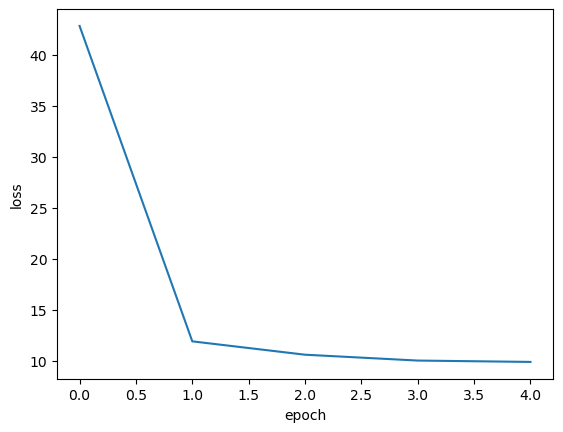

In [12]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [13]:
batch_size = 500
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
# Normalize the feature vectors.
feature_vectors = keras.utils.normalize(feature_vectors)


120/120 ━━━━━━━━━━━━━━━━━━━━ 75s 612ms/step


In [14]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = keras.ops.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))


100%|██████████| 120/120 [00:23<00:00,  5.07it/s]


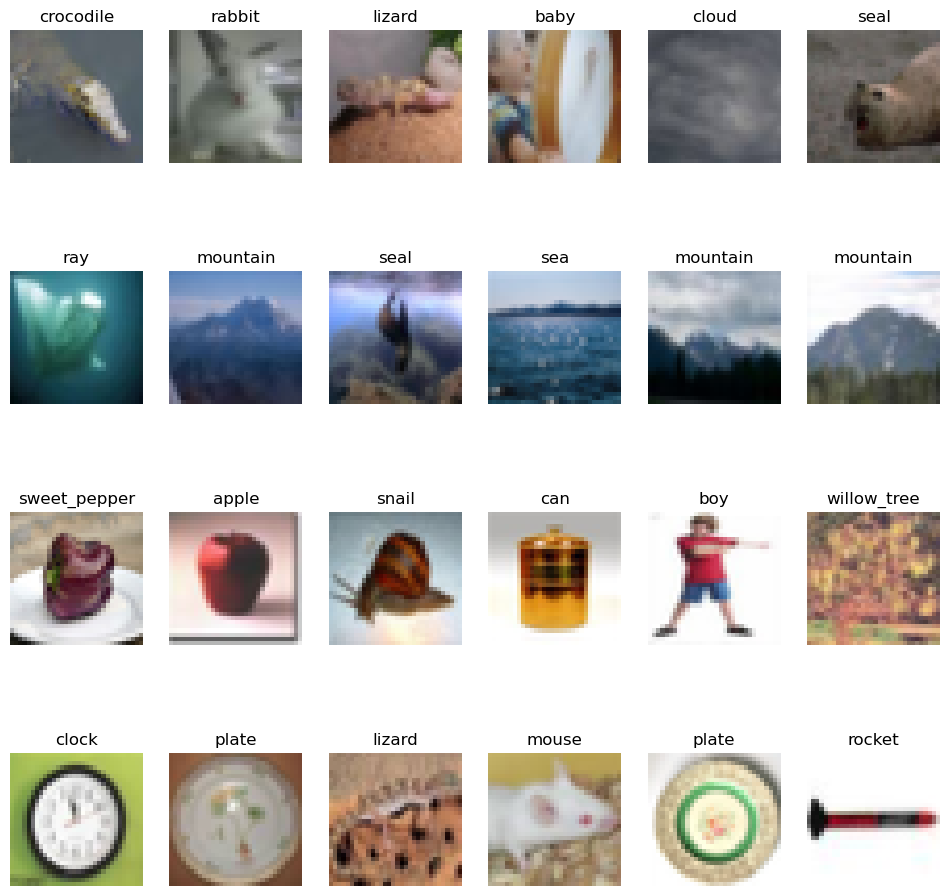

In [15]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indices = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indices.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.title(classes[y_data[indices[j]][0]])
        plt.axis("off")
        position += 1


In [16]:
class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = keras.ops.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return keras.ops.mean(loss)

In [17]:
class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = keras.ops.cast(
            keras.ops.shape(cluster_probabilities)[-1], "float32"
        )
        target = keras.ops.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = keras.ops.mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = keras.ops.clip(cluster_probabilities, 1e-8, 1.0)
        # Compute the entropy over the clusters.
        entropy = -keras.ops.sum(
            cluster_probabilities * keras.ops.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss



In [18]:
def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model

In [19]:
def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = keras.ops.reshape(neighbours, tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = keras.ops.reshape(
        neighbours_clustering,
        (-1, k_neighbours, keras.ops.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = keras.ops.einsum(
        "bij,bkj->bik",
        keras.ops.expand_dims(anchor_clustering, axis=1),
        neighbours_clustering,
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(
        lambda x: keras.ops.squeeze(x, axis=1), name="similarity"
    )(similarity)
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model

In [20]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering

# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)

# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]

# Create the model inputs and labels.
inputs = {"anchors": x_data, "neighbours": tf.gather(x_data, neighbours)}
labels = np.ones(shape=(x_data.shape[0]))

# Compile the model.
clustering_learner.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
    jit_compile=False,
)

# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=512, epochs=5)



Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 418s 3s/step - loss: 0.5027
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - loss: 0.3154
Epoch 3/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 450s 4s/step - loss: 0.3137
Epoch 4/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 496s 4s/step - loss: 0.3135
Epoch 5/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - loss: 0.3134


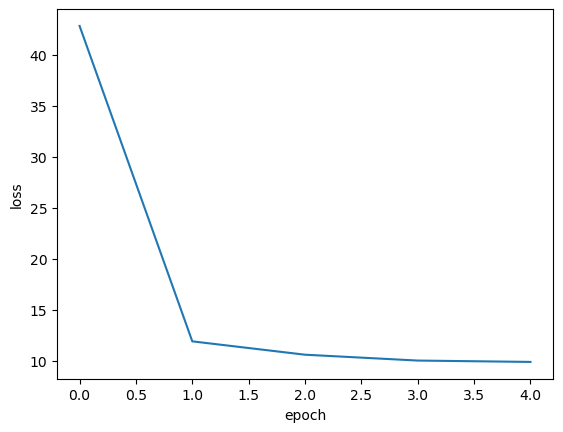

In [21]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [22]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_data, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = keras.ops.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = keras.ops.max(clustering_probs, axis=-1).numpy()


120/120 ━━━━━━━━━━━━━━━━━━━━ 72s 585ms/step


In [23]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

non_empty_clusters = defaultdict(list)
for c in clusters.keys():
    if clusters[c]:
        non_empty_clusters[c] = clusters[c]

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))


cluster 0 : 0
cluster 1 : 0
cluster 2 : 0
cluster 3 : 0
cluster 4 : 0
cluster 5 : 0
cluster 6 : 0
cluster 7 : 60000
cluster 8 : 0
cluster 9 : 0
cluster 10 : 0
cluster 11 : 0
cluster 12 : 0
cluster 13 : 0
cluster 14 : 0
cluster 15 : 0
cluster 16 : 0
cluster 17 : 0
cluster 18 : 0
cluster 19 : 0


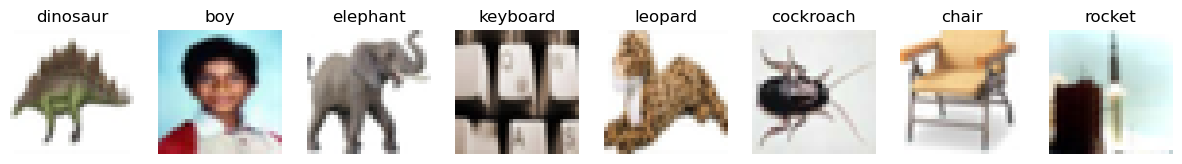

In [24]:
num_images = 8
plt.figure(figsize=(15, 15))
position = 1
for c in non_empty_clusters.keys():
    cluster_instances = sorted(
        non_empty_clusters[c], key=lambda kv: kv[1], reverse=True
    )

    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(len(non_empty_clusters), num_images, position)
        plt.imshow(x_data[image_idx].astype("uint8"))
        plt.title(classes[y_data[image_idx][0]])
        plt.axis("off")
        position += 1

In [25]:
cluster_label_counts = dict()

for c in range(num_clusters):
    cluster_label_counts[c] = [0] * num_classes
    instances = clusters[c]
    for i, _ in instances:
        cluster_label_counts[c][y_data[i][0]] += 1

    cluster_label_idx = np.argmax(cluster_label_counts[c])
    correct_count = np.max(cluster_label_counts[c])
    cluster_size = len(clusters[c])
    accuracy = (
        np.round((correct_count / cluster_size) * 100, 2) if cluster_size > 0 else 0
    )
    cluster_label = classes[cluster_label_idx]
    print("cluster", c, "label is:", cluster_label, " -  accuracy:", accuracy, "%")


cluster 0 label is: apple  -  accuracy: 0 %
cluster 1 label is: apple  -  accuracy: 0 %
cluster 2 label is: apple  -  accuracy: 0 %
cluster 3 label is: apple  -  accuracy: 0 %
cluster 4 label is: apple  -  accuracy: 0 %
cluster 5 label is: apple  -  accuracy: 0 %
cluster 6 label is: apple  -  accuracy: 0 %
cluster 7 label is: apple  -  accuracy: 1.0 %
cluster 8 label is: apple  -  accuracy: 0 %
cluster 9 label is: apple  -  accuracy: 0 %
cluster 10 label is: apple  -  accuracy: 0 %
cluster 11 label is: apple  -  accuracy: 0 %
cluster 12 label is: apple  -  accuracy: 0 %
cluster 13 label is: apple  -  accuracy: 0 %
cluster 14 label is: apple  -  accuracy: 0 %
cluster 15 label is: apple  -  accuracy: 0 %
cluster 16 label is: apple  -  accuracy: 0 %
cluster 17 label is: apple  -  accuracy: 0 %
cluster 18 label is: apple  -  accuracy: 0 %
cluster 19 label is: apple  -  accuracy: 0 %
